In [1]:
# 0) Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Load CSV
path = "rawdat.csv"   # change if needed
df = pd.read_csv(path)
df.head()  # preview

# 2) Choose feature columns (drop IDs / metadata)
id_cols = [c for c in ['sequence','run'] if c in df.columns]
feature_cols = [c for c in df.columns if c not in id_cols]
X = df[feature_cols].select_dtypes(include=[np.number])  # numeric-only
X.head()

# 3) Standardize features (mean=0, std=1)  -> PCA is scale-sensitive
scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(X)

# (optional) Save scaler stats
pd.DataFrame({"feature": X.columns, "mean": scaler.mean_, "scale": scaler.scale_}) \
  .to_csv("pca_scaler_stats.csv", index=False)

# 4) PCA
pca = PCA(n_components=None, svd_solver='auto', random_state=0)
scores = pca.fit_transform(X_std)  # PC coordinates per row

# 5) Explained variance tables
var_df = pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
    "explained_variance": pca.explained_variance_,
    "explained_variance_ratio": pca.explained_variance_ratio_,
    "cumulative_variance_ratio": np.cumsum(pca.explained_variance_ratio_)
})
var_df.to_csv("pca_variance.csv", index=False)
var_df.head(10)


,PC,explained_variance,explained_variance_ratio,cumulative_variance_ratio
0,PC1,3.611742,0.451466,0.451466
1,PC2,1.850941,0.231367,0.682833
2,PC3,1.006904,0.125863,0.808695
3,PC4,0.934888,0.116861,0.925556
4,PC5,0.270432,0.033804,0.959360
5,PC6,0.222726,0.027841,0.987200
6,PC7,0.100868,0.012608,0.999809
7,PC8,0.001529,0.000191,1.000000


In [2]:
# 6) Loadings (feature contributions)
# loadings = eigenvectors scaled by sqrt(eigenvalues)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=X.columns,
                           columns=[f"PC{i+1}" for i in range(loadings.shape[1])])
loadings_df.to_csv("pca_loadings.csv")
loadings_df.iloc[:, :8].head(20)  # first 8 PCs (preview)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
VDWAALS,0.825814,0.344476,0.008390,-0.000639,0.435718,-0.097010,-0.005916,0.001905
EEL,0.453479,-0.878920,0.034887,0.139984,0.013334,-0.007581,-0.006664,0.027710
EGB,-0.471754,0.865831,-0.032172,-0.150906,-0.045030,0.032318,0.012323,0.027492
ESURF,0.940329,0.121323,-0.047407,-0.104585,-0.107255,0.111164,0.253019,-0.000958
HB Energy,-0.155516,-0.338413,-0.113474,-0.918913,0.062504,0.004992,-0.009281,-0.000175
Hydrophobic Energy,0.910142,0.185827,0.043632,-0.073371,-0.073804,0.306419,-0.174606,-0.000774
Pi-Pi Energy,-0.023701,-0.033244,-0.990129,0.127591,0.020819,0.033215,-0.012860,0.000091
Delta_Entropy,0.874216,0.212680,-0.084847,-0.124572,-0.238925,-0.323782,-0.076677,0.000470


In [3]:
# 7) Scores (PC coordinates for each row) + keep IDs for reference
scores_df = pd.DataFrame(scores, columns=[f"PC{i+1}" for i in range(scores.shape[1])])
for c in id_cols:
    scores_df[c] = df[c].values
scores_df.to_csv("pca_scores.csv", index=False)
scores_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,sequence,run
0,-3.912558,-2.000607,-1.115073,-0.080687,-0.143040,0.072395,-0.005180,-0.009473,GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC,9
1,-2.643304,-1.748254,-1.134561,-0.228635,-0.137041,-0.165254,-0.522519,0.007691,GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC,9
2,-2.528297,-1.173045,-1.131841,-0.385940,-0.658008,0.699790,-0.950566,0.012296,GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC,9
3,-1.600319,-2.322789,-1.115152,-0.038907,-0.275683,0.076088,-0.524794,0.004503,GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC,9
4,-2.025500,-0.970647,-1.196990,-0.345244,-0.141655,0.016739,-0.187380,-0.048907,GCGCTGGGAGGCGAACACGTGCCCGCCGCCCCATCC,9


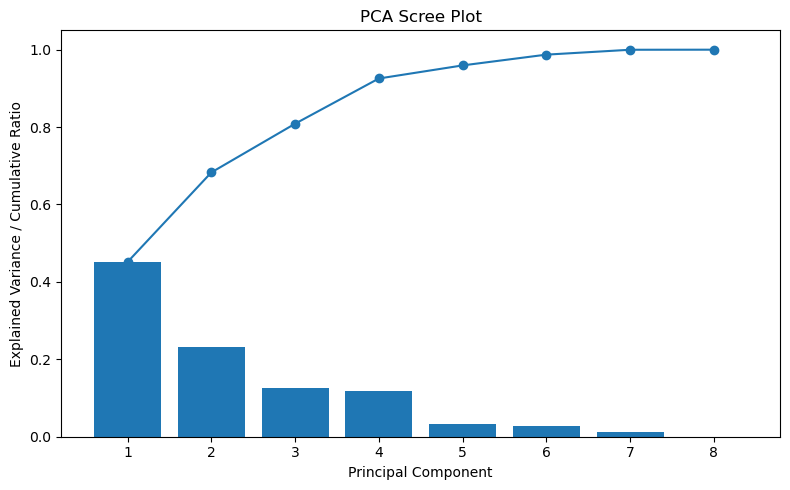

In [4]:
# 8) Scree plot: explained variance + cumulative
evr = pca.explained_variance_ratio_
cum = np.cumsum(evr)
plt.figure(figsize=(8, 5))
x = np.arange(1, len(evr) + 1)
plt.bar(x, evr)
plt.plot(x, cum, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance / Cumulative Ratio")
plt.title("PCA Scree Plot")
plt.tight_layout()
plt.show()


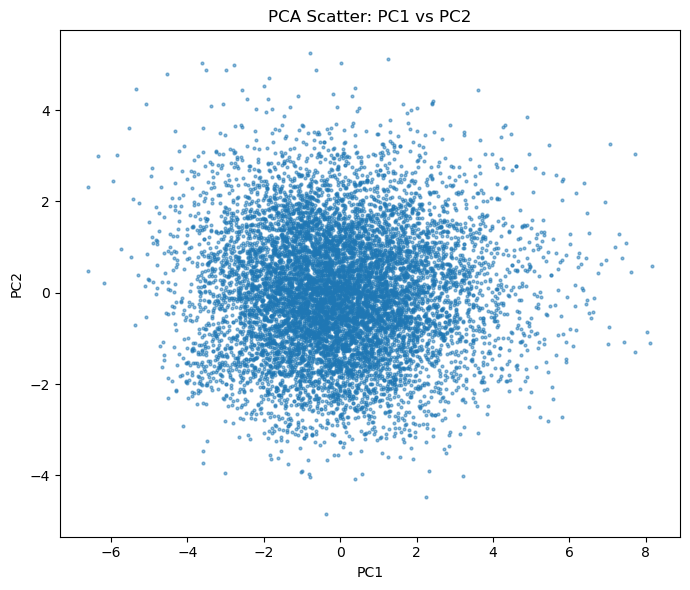

In [5]:
# 9) PC1 vs PC2 scatter (sample for speed if huge)
sample_n = min(len(scores_df), 10_000)
sample = scores_df.sample(sample_n, random_state=0)

plt.figure(figsize=(7, 6))
plt.scatter(sample["PC1"], sample["PC2"], s=4, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter: PC1 vs PC2")
plt.tight_layout()
plt.show()
